In [7]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.model_selection import PredefinedSplit
from xgboost import XGBRegressor
from skopt import BayesSearchCV
from skopt.space import Real, Integer
import warnings
warnings.filterwarnings("ignore")

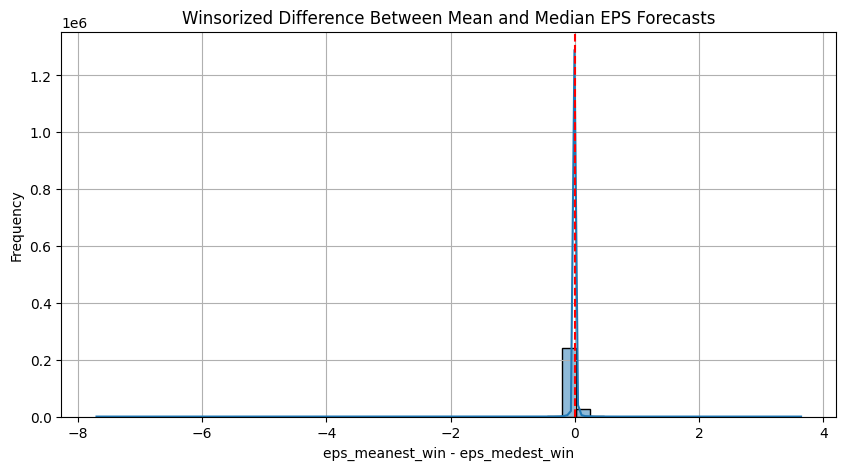

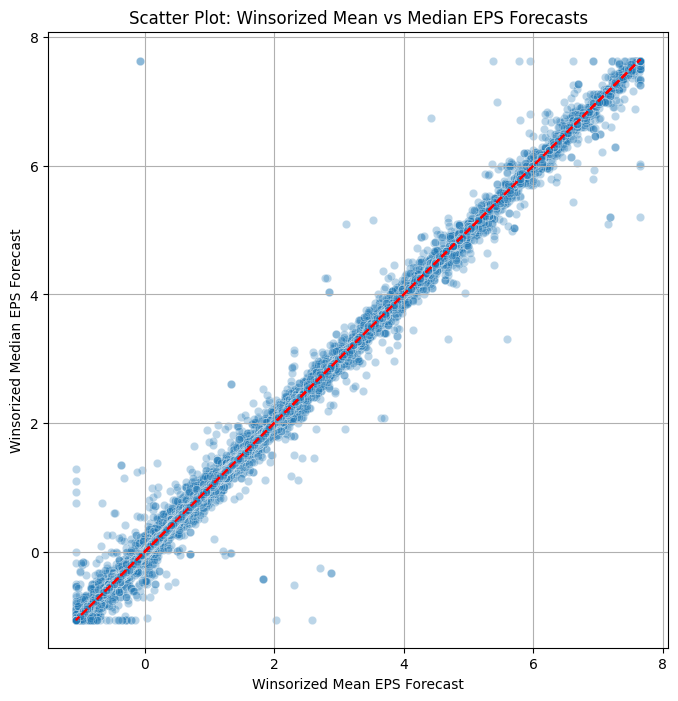

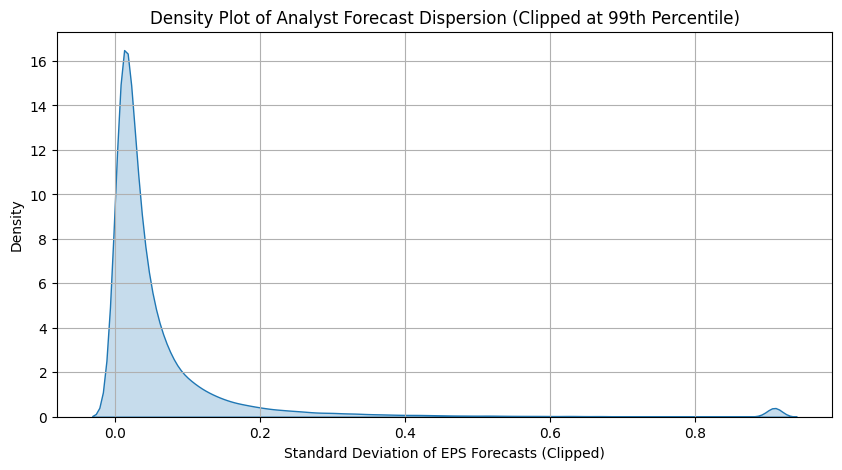

In [8]:
### Analyse which is the best median or mean forecast to use in the target variable
# Mean forecast behave very similar to the median forecast, when dispersion is low
# Mean forecast is more sensitive to outliers, when dispersion is high. That's when median is better

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats.mstats import winsorize
import numpy as np

df = pd.read_csv("mma_sample_v2.csv", parse_dates=["date"])
# Drop rows with missing forecast data
df = df.dropna(subset=["eps_meanest", "eps_medest", "eps_stdevest"])

# Winsorize eps_meanest and eps_medest (clip bottom and top 1%)
df['eps_meanest_win'] = winsorize(df['eps_meanest'], limits=[0.01, 0.01])
df['eps_medest_win'] = winsorize(df['eps_medest'], limits=[0.01, 0.01])

# Recalculate difference after winsorizing
df['mean_median_diff'] = df['eps_meanest_win'] - df['eps_medest_win']

# --- Plot 1: Histogram of mean vs median differences ---
plt.figure(figsize=(10, 5))
sns.histplot(df['mean_median_diff'], bins=50, kde=True)
plt.title("Winsorized Difference Between Mean and Median EPS Forecasts")
plt.xlabel("eps_meanest_win - eps_medest_win")
plt.ylabel("Frequency")
plt.axvline(0, color='red', linestyle='--')
plt.grid(True)
plt.show()

# --- Plot 2: Scatter plot mean vs median ---
plt.figure(figsize=(8, 8))
sns.scatterplot(x='eps_meanest_win', y='eps_medest_win', data=df, alpha=0.3)
plt.plot(df['eps_meanest_win'], df['eps_meanest_win'], color='red', linestyle='--')  # y = x
plt.title("Scatter Plot: Winsorized Mean vs Median EPS Forecasts")
plt.xlabel("Winsorized Mean EPS Forecast")
plt.ylabel("Winsorized Median EPS Forecast")
plt.grid(True)
plt.show()

# --- Plot 3: Density of forecast dispersion (no winsorization here) ---
# Define a reasonable clipping threshold — e.g., 99th percentile
clip_threshold = df['eps_stdevest'].quantile(0.99)

# Create a clipped version of eps_stdevest just for plotting
df['eps_stdevest_clip'] = np.where(df['eps_stdevest'] > clip_threshold, clip_threshold, df['eps_stdevest'])

# Plot clipped version
plt.figure(figsize=(10, 5))
sns.kdeplot(df['eps_stdevest_clip'], shade=True)
plt.title("Density Plot of Analyst Forecast Dispersion (Clipped at 99th Percentile)")
plt.xlabel("Standard Deviation of EPS Forecasts (Clipped)")
plt.grid(True)
plt.show()



In [16]:
import pandas as pd
import numpy as np
# from sklearn.preprocessing import StandardScaler # No longer needed
from skopt import BayesSearchCV
from skopt.space import Real, Integer
from sklearn.model_selection import PredefinedSplit
from xgboost import XGBClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    classification_report,
    make_scorer
)



In [10]:
# === Step 1: Load Data ===
df = pd.read_csv("mma_sample_v2.csv", parse_dates=["date"])
factors = pd.read_csv("factor_char_list.csv")["variable"].tolist()

df["date"] = df["date"].dt.to_period("M").dt.to_timestamp()

# Compute EPS surprise
df = df.dropna(subset=["eps_medest","eps_actual"])
df["eps_surprise_pct"] = (df["eps_actual"] - df["eps_medest"]) / df["eps_medest"].abs()
    #Choose the threshold like 0% or 5%
df['eps_surprise_binary'] = (df['eps_surprise_pct'] > 0).astype(int)

df = df.dropna(subset=["eps_surprise_pct", "eps_surprise_binary"])

<Figure size 1000x600 with 0 Axes>

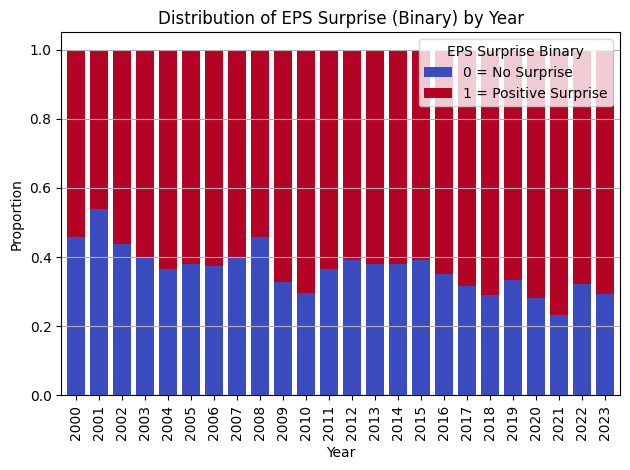

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Count positive vs non-positive EPS surprises by year
yearly_counts = df.groupby(['year', 'eps_surprise_binary']).size().unstack(fill_value=0)
yearly_props = yearly_counts.div(yearly_counts.sum(axis=1), axis=0)
plt.figure(figsize=(10, 6))
yearly_props.plot(kind='bar', stacked=True, colormap='coolwarm', width=0.8)

plt.title("Distribution of EPS Surprise (Binary) by Year")
plt.xlabel("Year")
plt.ylabel("Proportion")
plt.legend(title='EPS Surprise Binary', labels=['0 = No Surprise', '1 = Positive Surprise'])
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [17]:
# === Step2 : Help functions to windorize and rank transformation
def calculate_windorize_thresholds(df_factors, lower_percentile, upper_percentile):
    if not isinstance(df_factors, pd.DataFrame):
         raise TypeError("Input df_factors must be a pandas DataFrame.")
    lower_thresholds = df_factors.quantile(lower_percentile, axis=0)
    upper_thresholds = df_factors.quantile(upper_percentile, axis=0)

    return lower_thresholds, upper_thresholds

def apply_windorize_thresholds(df_to_clip, factors, lower_thresholds, upper_thresholds):
    if not isinstance(df_to_clip, pd.DataFrame):
         raise TypeError("Input df_to_clip must be a pandas DataFrame.")
    if not all(col in df_to_clip.columns for col in factors):
         raise ValueError("Not all factor columns found in df_to_clip.")
    # Apply clipping using the calculated thresholds
    df_clipped = df_to_clip.copy() # Work on a copy to avoid modifying original slices unexpectedly
    df_clipped[factors] = df_to_clip[factors].clip(lower=lower_thresholds, upper=upper_thresholds, axis=1)

    return df_clipped

def rank_transform_monthly(df, factors):
    """
    Applies monthly rank transformation to specified factor columns in a DataFrame.
    Includes median imputation and normalization to [-1, 1].
    """
    df_processed = df.copy() # Work on a copy
    monthly_grouped = df_processed.groupby(["year", "month"])
    processed_factor_data = []

    for (yr, mo), grp in monthly_grouped:
        group = grp.copy() # Work on a copy of the group
        for var in factors:
            # 1. Median Imputation
            med = group[var].median(skipna=True)
            group[var] = group[var].fillna(med)
            # 2. Rank Transformation
            group[var] = group[var].rank(method="dense", na_option='keep') - 1 # na_option='keep' is safer though fillna done first
            # 3. Normalization to [-1, 1]
            max_rank = group[var].max()
            # Avoid division by zero if all values in the group are the same (max_rank=0)
            group[var] = (group[var] / max_rank) * 2 - 1 if max_rank > 0 else 0
        # Keep only the processed factors for this group
        processed_factor_data.append(group[factors])

    # Combine the processed factors from all months
    if processed_factor_data:
        ranked_df = pd.concat(processed_factor_data).sort_index()
    else:
        ranked_df = pd.DataFrame(index=df_processed.index, columns=factors)
    # Return as numpy array
    return ranked_df.values

In [18]:
# === Step 2: Expanding Window with Bayesian Optimization ===
results = []
metrics_history=[]
starting = pd.to_datetime("20000101")
counter = 0

#windorize percentiles
lower_pct=0.01
upper_pct=0.99
target = "eps_surprise_binary"

while (starting + pd.DateOffset(years=11 + counter)) <= pd.to_datetime("20240101"):
    cutoff = [
        starting,
        starting + pd.DateOffset(years=8 + counter),
        starting + pd.DateOffset(years=10 + counter),
        starting + pd.DateOffset(years=11 + counter)
    ]
    train_df = df[(df["date"] >= cutoff[0]) & (df["date"] < cutoff[1])]
    val_df   = df[(df["date"] >= cutoff[1]) & (df["date"] < cutoff[2])]
    test_df  = df[(df["date"] >= cutoff[2]) & (df["date"] < cutoff[3])]

    if train_df.empty or val_df.empty or test_df.empty:
        counter += 1
        continue
    
    y_train=train_df[target].values
    y_val=val_df[target].values
    y_test=test_df[target].values
    # === Preprocessing ===
    #1. Windorize
    lower_thresh, upper_thresh = calculate_windorize_thresholds(train_df[factors], lower_pct, upper_pct)
    train_df_wind = apply_windorize_thresholds(train_df.copy(), factors, lower_thresh, upper_thresh)
    val_df_wind   = apply_windorize_thresholds(val_df.copy(), factors, lower_thresh, upper_thresh)
    test_df_wind  = apply_windorize_thresholds(test_df.copy(), factors, lower_thresh, upper_thresh)
    #2. Monthly Rank Transformation
    X_train_ranked = rank_transform_monthly(train_df_wind, factors)
    X_val_ranked   = rank_transform_monthly(val_df_wind, factors)
    X_test_ranked  = rank_transform_monthly(test_df_wind, factors)

    # Combine for tuning
    X_comb = np.vstack([X_train_ranked, X_val_ranked])
    y_comb = np.concatenate([y_train, y_val])
    split_idx = [-1] * len(X_train_ranked) + [0] * len(X_val_ranked)
    ps = PredefinedSplit(test_fold=split_idx)

    # === Bayesian Optimization ===
    precision_class1 = make_scorer(precision_score, pos_label=1)

    bayes_cv = BayesSearchCV(
        XGBClassifier(objective="binary:logistic", random_state=42, use_label_encoder=False, eval_metric='logloss'),
        search_spaces={
            'learning_rate': Real(0.01, 0.3, prior='log-uniform'),
            'max_depth': Integer(3, 7),
            'subsample': Real(0.5, 1.0),
            'colsample_bytree': Real(0.5, 1.0),
            'n_estimators': Integer(50, 300),
            'reg_alpha': Real(1e-9, 100, prior='log-uniform'),
            'reg_lambda': Real(1e-9, 100, prior='log-uniform'),
        },
        n_iter=20,
        scoring=precision_class1, # Use precision for positive eps surprise
        cv=ps, # Use the predefined train/validation split
        refit=True, # Refit on train+val after finding best params
        random_state=42,
        verbose=0
    )
    bayes_cv.fit(X_comb, y_comb)
    model = bayes_cv.best_estimator_
    best_params = bayes_cv.best_params_

    # === Predict and store ===
    test_pred_proba = model.predict_proba(X_test_ranked)[:, 1]
    # Convert probabilities to binary predictions using a threshold (default is 0.5)
    threshold = 0.5
    test_pred_binary = (test_pred_proba > threshold).astype(int)
    # Store results for potential later analysis
    temp_df = test_df[["permno", "date"]].copy() # Keep original date/permno
    temp_df["actual"] = y_test
    temp_df["pred_proba"] = test_pred_proba
    temp_df["pred_binary"] = test_pred_binary
    results.append(temp_df)
    # Calculate Metrics for this window
    window_metrics = {
            "window": counter + 1,
            "start_date": cutoff[0],
            "end_date": cutoff[3],
            "n_test_samples": len(y_test),
            "accuracy": accuracy_score(y_test, test_pred_binary),
            "precision": precision_score(y_test, test_pred_binary, zero_division=0),
            "recall": recall_score(y_test, test_pred_binary, zero_division=0),
            "f1_score": f1_score(y_test, test_pred_binary, zero_division=0),
             # Check if y_test contains both classes before calculating AUC
            "roc_auc": roc_auc_score(y_test, test_pred_proba) if len(np.unique(y_test)) > 1 else np.nan,
            "best_params": best_params # Store found params
    }
    metrics_history.append(window_metrics)
    print(f"✅ Window {counter + 1}")
    print(classification_report(y_test, test_pred_binary, target_names=['Predicted 0', 'Predicted 1'], digits=4))

    counter += 1

final_results_df = pd.concat(results, ignore_index=True)
metrics_df = pd.DataFrame(metrics_history)  


✅ Window 1
              precision    recall  f1-score   support

 Predicted 0     0.4248    0.2936    0.3472      3110
 Predicted 1     0.7372    0.8330    0.7822      7399

    accuracy                         0.6733     10509
   macro avg     0.5810    0.5633    0.5647     10509
weighted avg     0.6448    0.6733    0.6534     10509

✅ Window 2
              precision    recall  f1-score   support

 Predicted 0     0.5512    0.2697    0.3622      3793
 Predicted 1     0.6760    0.8740    0.7624      6613

    accuracy                         0.6538     10406
   macro avg     0.6136    0.5719    0.5623     10406
weighted avg     0.6305    0.6538    0.6165     10406

✅ Window 3
              precision    recall  f1-score   support

 Predicted 0     0.5083    0.3775    0.4333      4124
 Predicted 1     0.6554    0.7643    0.7057      6389

    accuracy                         0.6126     10513
   macro avg     0.5819    0.5709    0.5695     10513
weighted avg     0.5977    0.6126    0.59

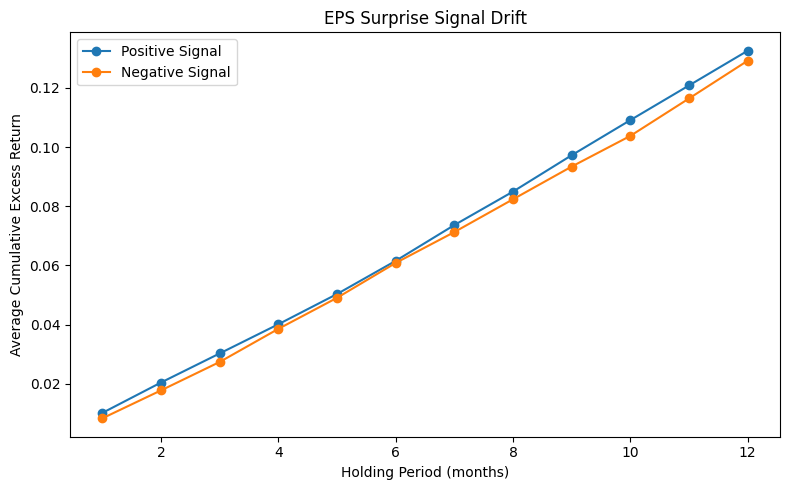

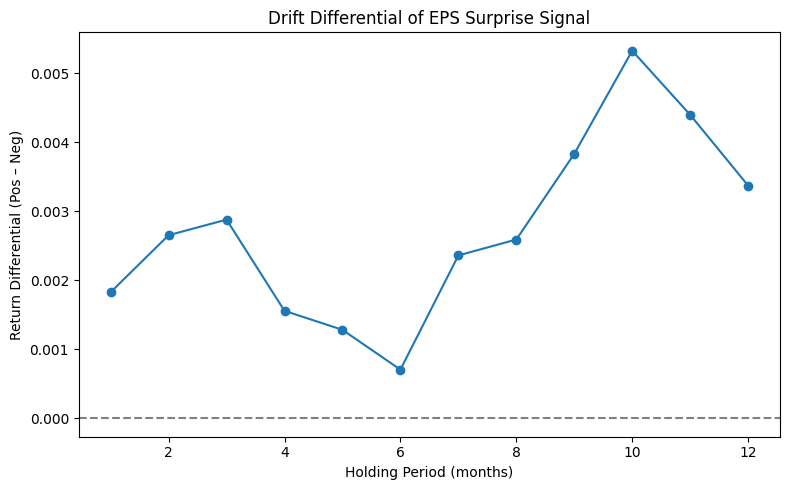

In [19]:
# === Step 3: Drift Analysis from the EPS surprise signal ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = (
    final_results_df
    .merge(df.rename(columns={"stock_exret": "excess_return"}), on=["permno","date"], how="left")
    .sort_values(["permno","date"])
)
horizons = list(range(1, 13)) #Define holding periods 1 to 12 months
# Compute forward returns for each horizon
def compute_forward_cumrets(group):
    group = group.copy()
    rets = group["excess_return"]
    for h in horizons:
        group[f"cum_return_{h}m"] = ( # rolling window of length h, compute product(1+ret)-1, then shift so result aligns to the trade date
            rets
            .rolling(window=h, min_periods=h)
            .apply(lambda x: np.prod(1 + x) - 1, raw=False)
            .shift(-(h - 1))
        )
    return group
df_forward = df.groupby("permno").apply(compute_forward_cumrets).reset_index(drop=True)

#Compute average cumulative returns by binary signal
avg_cumrets = (
    df_forward
    .groupby("pred_binary")[[f"cum_return_{h}m" for h in horizons]]
    .mean()
    .T
)
avg_cumrets.index = horizons
avg_cumrets.columns = ["Negative Signal", "Positive Signal"]

#Drift curve
plt.figure(figsize=(8,5))
plt.plot(avg_cumrets.index, avg_cumrets["Positive Signal"], marker='o', label="Positive Signal")
plt.plot(avg_cumrets.index, avg_cumrets["Negative Signal"], marker='o', label="Negative Signal")
plt.xlabel("Holding Period (months)")
plt.ylabel("Average Cumulative Excess Return")
plt.title("EPS Surprise Signal Drift")
plt.legend()
plt.tight_layout()
plt.show()

# Plot the differential between signals
diff = avg_cumrets["Positive Signal"] - avg_cumrets["Negative Signal"]
plt.figure(figsize=(8,5))
plt.plot(horizons, diff, marker='o')
plt.axhline(0, color='gray', linestyle='--')
plt.xlabel("Holding Period (months)")
plt.ylabel("Return Differential (Pos – Neg)")
plt.title("Drift Differential of EPS Surprise Signal")
plt.tight_layout()
plt.show()

In [23]:
final_results_df.to_csv("predictions_eps_surprise_0.csv")
metrics_df.to_csv("metrics_eps_surprise_0.csv")

# Step 4: Build Portfolio

In [50]:
df = df.drop(columns=['pred_proba', 'pred_binary', 'actual'])
df=df.rename(columns={"excess_return": "stock_exret"})

In [ ]:
final_results_df['date'] = pd.to_datetime(final_results_df['date'])
final_results_df['year'] = final_results_df['date'].dt.year
final_results_df['month'] = final_results_df['date'].dt.month

Starting Backtesting Loop...
Backtesting Loop - Complete

Calculating performance metrics...

Performance Metrics:
Strategy                                SPY500 Pure_EPS_Momentum_YearMonth
Annual Return (%)                        12.06                       14.24
Annualized Volatility (%)                14.63                       17.72
Annualized Sharpe Ratio                  0.751                       0.743
Annualized Alpha vs SP500 (%)             0.00                        1.55
Beta vs SP500                            1.000                       1.077
Annualized Information Ratio vs SP500      nan                       0.294
Annualized Tracking Error vs SP500 (%)    0.00                        8.27
Max Drawdown (%)                        -24.77                      -23.90
Max Monthly Loss (%)                    -12.51                      -12.49
Average Monthly Turnover (%)               nan                       16.64
Average Portfolio Size                     nan              

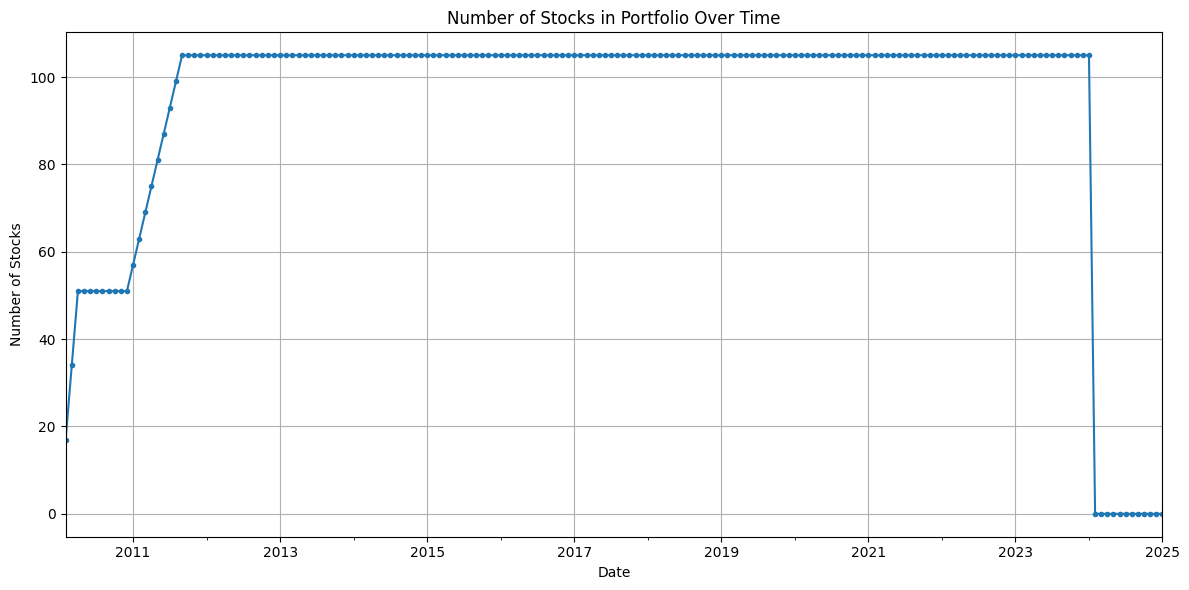


Generating cumulative return plot...


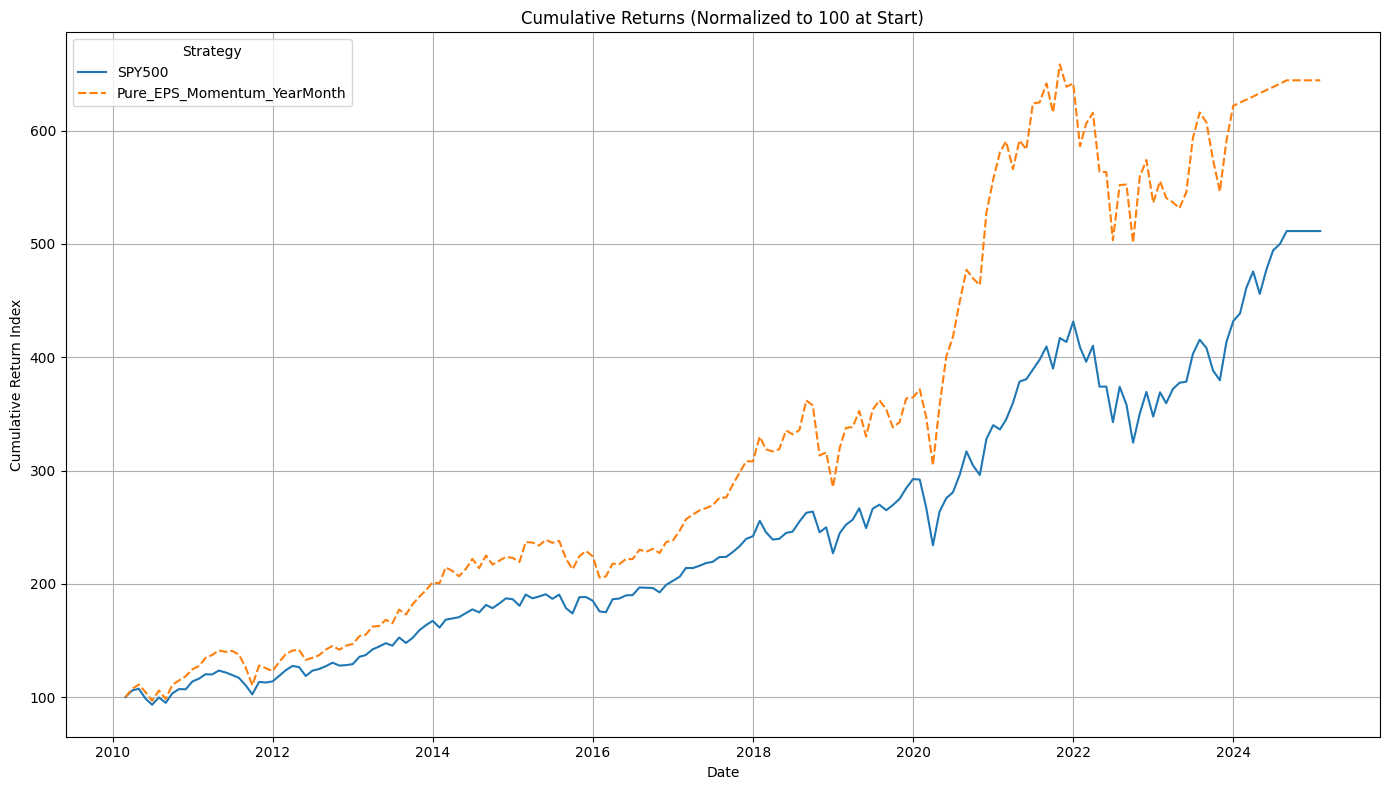


Analysis complete.


In [79]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from datetime import timedelta, datetime
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import math 

# Suppress specific warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)

# --- 1. Data Loading and Preparation (Original structure maintained) ---
all_data = df.copy()
mkt = pd.read_csv("mkt_ind1.csv")

# --- Merge Data (using year and month primarily if date objects are problematic) ---
all_data = all_data.merge(
    final_results_df[['permno', 'year', 'month','pred_proba', 'pred_binary']],
    on=['permno', 'year', 'month'], # original merge keys
    how='left',
)
all_data = all_data.sort_values(['permno', 'year', 'month']).reset_index(drop=True)

# --- Calculate Momentum ---
def calculate_12_1_momentum(data):
    df_m = data.copy()
    if 'stock_exret' not in df_m.columns:
        df_m['stock_exret'] = 0.0 # Should not happen with proper data
    df_m['1+stock_exret'] = 1 + df_m['stock_exret'].fillna(0)
    df_m['comp_ret_11m_end_t'] = df_m.groupby('permno')['1+stock_exret'].transform(
        lambda x: x.rolling(window=11, min_periods=11).apply(np.prod, raw=True)
    )
    df_m['mom_12_1m'] = df_m.groupby('permno')['comp_ret_11m_end_t'].shift(1) - 1
    return df_m.drop(columns=['1+stock_exret', 'comp_ret_11m_end_t'], errors='ignore')

all_data = calculate_12_1_momentum(all_data)

# Prepare mkt lookups (RF and SPY) once
mkt_year_month_indexed = mkt.set_index(['year', 'month'])
mkt_rf_series = mkt_year_month_indexed['RF']
mkt_spy_series = mkt_year_month_indexed['sp_ret']

# --- Strategy Parameters ---
STRATEGY_NAME = "Pure_EPS_Momentum_YearMonth" 
H_EPS = 3  
NEW_STOCKS_PER_MONTH_EPS = 17 
H_MOM = 9  
NEW_STOCKS_PER_MONTH_MOM = 6  
CONSTRAINTS = {"max_stock_weight": 0.10}

# Define trade periods using year and month
START_YEAR, START_MONTH = 2010, 1
END_DATA_YEAR, END_DATA_MONTH = 2024, 12 # Last month for which returns data is available

END_DECISION_YEAR, END_DECISION_MONTH = 2024, 12 #End year and month decision

TRADE_PERIODS = []
current_year, current_month = START_YEAR, START_MONTH
while (current_year < END_DECISION_YEAR) or \
      (current_year == END_DECISION_YEAR and current_month <= END_DECISION_MONTH):
    TRADE_PERIODS.append((current_year, current_month))
    temp_date = datetime(current_year, current_month, 1) + relativedelta(months=1)
    current_year, current_month = temp_date.year, temp_date.month

# --- Monthly Portfolio Function (Using Year/Month) ---
def get_shifted_period(year, month, month_offset):
    """Calculates a new (year, month) after applying a month_offset."""
    current_date = datetime(year, month, 1)
    shifted_date = current_date + relativedelta(months=month_offset)
    return shifted_date.year, shifted_date.month

def select_stocks_for_combined_strategy(decision_year, decision_month, all_data_for_selection, 
                                        prev_portfolio_state, constraints, 
                                        h_eps, num_new_eps_monthly, 
                                        h_mom, num_new_mom_monthly):
    
    sell_eps_entry_year, sell_eps_entry_month = get_shifted_period(decision_year, decision_month, -h_eps)
    sell_mom_entry_year, sell_mom_entry_month = get_shifted_period(decision_year, decision_month, -h_mom)
    
    kept_holdings = []
    for holding in prev_portfolio_state:
        sell_stock = False
        entry_yr, entry_mn = holding['entry_period']
        if holding['type'] == 'eps' and (entry_yr, entry_mn) == (sell_eps_entry_year, sell_eps_entry_month):
            sell_stock = True
        elif holding['type'] == 'mom' and (entry_yr, entry_mn) == (sell_mom_entry_year, sell_mom_entry_month):
            sell_stock = True
        
        if not sell_stock:
            kept_holdings.append(holding)
            
    kept_permnos = {h['permno'] for h in kept_holdings}
    
    data_today = all_data_for_selection[
        (all_data_for_selection['year'] == decision_year) & 
        (all_data_for_selection['month'] == decision_month)
    ].copy()
    
    if data_today.empty:
        return [], kept_holdings, [], []

    eps_candidates_pool_filtered = data_today[
        (data_today['pred_binary'] == 1) & 
        (~data_today['permno'].isin(kept_permnos))
    ]
    eps_candidates_pool_ranked = eps_candidates_pool_filtered.dropna(
        subset=['pred_proba']
    ).sort_values('pred_proba', ascending=False)
    
    newly_selected_eps_permnos = eps_candidates_pool_ranked['permno'].head(num_new_eps_monthly).tolist()
    new_eps_holdings = [{'permno': p, 'entry_period': (decision_year, decision_month), 'type': 'eps'} for p in newly_selected_eps_permnos]
    
    permnos_unavailable_for_mom = kept_permnos.union(set(newly_selected_eps_permnos))
    
    mom_candidates_pool_filtered = data_today[
        ~data_today['permno'].isin(permnos_unavailable_for_mom)
    ]
    mom_candidates_pool_ranked = mom_candidates_pool_filtered.dropna(
        subset=['mom_12_1m']
    ).sort_values('mom_12_1m', ascending=False)
    
    newly_selected_mom_permnos = mom_candidates_pool_ranked['permno'].head(num_new_mom_monthly).tolist()
    new_mom_holdings = [{'permno': p, 'entry_period': (decision_year, decision_month), 'type': 'mom'} for p in newly_selected_mom_permnos]

    current_portfolio_details = kept_holdings + new_eps_holdings + new_mom_holdings
    portfolio_permnos_for_weighting = [h['permno'] for h in current_portfolio_details]
    
    if not portfolio_permnos_for_weighting:
        return [], current_portfolio_details, [], []

    num_unique_stocks = len(portfolio_permnos_for_weighting)
    base_w = 1.0 / num_unique_stocks
    weights = {permno: base_w for permno in portfolio_permnos_for_weighting}
    
    max_w = constraints.get('max_stock_weight', 1.0)
    iteration = 0
    while iteration < 10: 
        over_constraint_permnos = [p for p, w in weights.items() if w > max_w + 1e-9] 
        if not over_constraint_permnos: break 
        excess_weight_total = sum(weights[p] - max_w for p in over_constraint_permnos)
        for p in over_constraint_permnos: weights[p] = max_w
        under_constraint_permnos = [p for p, w in weights.items() if w < max_w - 1e-9 and p not in over_constraint_permnos]
        if not under_constraint_permnos or abs(excess_weight_total) < 1e-9: break 
        sum_weights_eligible_for_redistribution = sum(weights[p] for p in under_constraint_permnos)
        if sum_weights_eligible_for_redistribution > 1e-9:
            for p in under_constraint_permnos:
                weights[p] += (weights[p] / sum_weights_eligible_for_redistribution) * excess_weight_total
        else: break 
        iteration += 1
    
    total_current_weight = sum(weights.values())
    if abs(total_current_weight - 1.0) > 1e-9 and total_current_weight > 1e-9 : 
        weights = {p: w / total_current_weight for p, w in weights.items()}
        
    portfolio_with_weights = list(weights.items())
    prev_portfolio_permnos = {h['permno'] for h in prev_portfolio_state}
    current_portfolio_permnos_set = {p for p, w in portfolio_with_weights}
    buys = list(current_portfolio_permnos_set - prev_portfolio_permnos)
    sells = list(prev_portfolio_permnos - current_portfolio_permnos_set)
    
    return portfolio_with_weights, current_portfolio_details, buys, sells

# --- 4. Backtesting Loop ---
strategy_results = {}
monthly_returns, monthly_turnover_buys, monthly_turnover_sells, portfolio_sizes_ts = [], [], [], [] 
portfolio_state = [] 
portfolio_composition_log = [] 

print("Starting Backtesting Loop...")
if all_data.empty:
    print("WARNING: `all_data` is empty. Backtesting loop will not run effectively.")
if not TRADE_PERIODS:
    print("WARNING: TRADE_PERIODS is empty. Backtesting loop will be skipped.")

for i, (decision_year, decision_month) in enumerate(TRADE_PERIODS):
    current_portfolio_weights_tuples, current_portfolio_details_list, buys, sells = select_stocks_for_combined_strategy(
        decision_year, decision_month, all_data, portfolio_state, CONSTRAINTS, 
        H_EPS, NEW_STOCKS_PER_MONTH_EPS, H_MOM, NEW_STOCKS_PER_MONTH_MOM
    )
    
    portfolio_state = current_portfolio_details_list 
    portfolio_sizes_ts.append(len(current_portfolio_weights_tuples))
    
    if i < 12 and len(current_portfolio_weights_tuples) == 0 : # Check for first few months
         print(f"WARNING on {decision_year}-{decision_month:02d}: No stocks selected. Portfolio size: {len(current_portfolio_weights_tuples)}")

    num_stocks_in_current_weighted_portfolio = len(current_portfolio_weights_tuples)
    monthly_turnover_buys.append(len(buys) / max(1, num_stocks_in_current_weighted_portfolio))
    monthly_turnover_sells.append(len(sells) / max(1, num_stocks_in_current_weighted_portfolio))
    
    holding_returns_year, holding_returns_month = get_shifted_period(decision_year, decision_month, 1)
    returns_data_for_month = all_data[
        (all_data['year'] == holding_returns_year) & 
        (all_data['month'] == holding_returns_month)
    ].set_index('permno')
    
    port_ex_ret = 0.0
    permno_to_type_map = {detail['permno']: detail['type'] for detail in current_portfolio_details_list}

    if not returns_data_for_month.empty and current_portfolio_weights_tuples:
        for permno, weight in current_portfolio_weights_tuples:
            stock_exret_for_holding_period = 0.0 
            if permno in returns_data_for_month.index:
                ret = returns_data_for_month.loc[permno, 'stock_exret']
                if pd.notna(ret): stock_exret_for_holding_period = ret
            port_ex_ret += weight * stock_exret_for_holding_period
            strategy_type = permno_to_type_map.get(permno, 'unknown')
            portfolio_composition_log.append({
                'year': decision_year, 'month': decision_month, 'permno': permno,
                'strategy_type': strategy_type, 'weight': weight,
                'stock_exret_holding_period': stock_exret_for_holding_period,
                'contribution_to_portfolio_ex_return': weight * stock_exret_for_holding_period
            })
    elif current_portfolio_weights_tuples: # Stocks selected but no returns data
        for permno, weight in current_portfolio_weights_tuples:
            strategy_type = permno_to_type_map.get(permno, 'unknown')
            portfolio_composition_log.append({
                'year': decision_year, 'month': decision_month, 'permno': permno,
                'strategy_type': strategy_type, 'weight': weight,
                'stock_exret_holding_period': 0.0,
                'contribution_to_portfolio_ex_return': 0.0
            })
            
    rf_rate = mkt_rf_series.get((holding_returns_year, holding_returns_month), 0.0) 
    monthly_returns.append(port_ex_ret + rf_rate)

print("Backtesting Loop - Complete")
portfolio_composition_df = pd.DataFrame(portfolio_composition_log)

# --- Result Aggregation ---
returns_index = pd.DatetimeIndex([])
if TRADE_PERIODS:
    holding_periods_dt = []
    for yr, mn in TRADE_PERIODS:
        h_yr, h_mn = get_shifted_period(yr, mn, 1)
        # Use end of month for the index
        holding_periods_dt.append(pd.Timestamp(year=h_yr, month=h_mn, day=1) + pd.offsets.MonthEnd(0))
    if holding_periods_dt:
        returns_index = pd.DatetimeIndex(holding_periods_dt)

num_expected_returns = len(TRADE_PERIODS)
if len(monthly_returns) == len(returns_index) and num_expected_returns == len(returns_index) and not returns_index.empty:
    strategy_results[STRATEGY_NAME] = {
        'monthly_returns': pd.Series(monthly_returns, index=returns_index),
        'monthly_turnover_buys': pd.Series(monthly_turnover_buys, index=returns_index),
        'monthly_turnover_sells': pd.Series(monthly_turnover_sells, index=returns_index),
        'portfolio_sizes': pd.Series(portfolio_sizes_ts, index=returns_index) 
    }
else:
    print(f"Warning: Length mismatch for {STRATEGY_NAME} results. Expected: {num_expected_returns}, Got Returns: {len(monthly_returns)}, Index: {len(returns_index)}")
    # Fallback for mismatched lengths or empty index
    min_len = 0
    if not returns_index.empty: # Only proceed if returns_index is valid
        min_len = min(len(monthly_returns), len(returns_index))
    
    strategy_results[STRATEGY_NAME] = {
        'monthly_returns': pd.Series(monthly_returns[:min_len], index=returns_index[:min_len]) if min_len > 0 else pd.Series(dtype='float64'),
        'monthly_turnover_buys': pd.Series(monthly_turnover_buys[:min_len], index=returns_index[:min_len]) if min_len > 0 else pd.Series(dtype='float64'),
        'monthly_turnover_sells': pd.Series(monthly_turnover_sells[:min_len], index=returns_index[:min_len]) if min_len > 0 else pd.Series(dtype='float64'),
        'portfolio_sizes': pd.Series(portfolio_sizes_ts[:min_len], index=returns_index[:min_len]) if min_len > 0 else pd.Series(dtype='float64')
    }


# --- Add SPY 500 as Benchmark ---
current_returns_idx = strategy_results.get(STRATEGY_NAME, {}).get('monthly_returns', pd.Series(dtype=float)).index
if not current_returns_idx.empty:
    year_month_tuples = [(d.year, d.month) for d in current_returns_idx]
    spy_returns_aligned = pd.Series(index=current_returns_idx, dtype=float)
    for i, ym_tuple in enumerate(year_month_tuples):
        spy_returns_aligned.iloc[i] = mkt_spy_series.get(ym_tuple, np.nan)
    strategy_results['SPY500'] = {'monthly_returns': spy_returns_aligned}
else:
    strategy_results['SPY500'] = {'monthly_returns': pd.Series(dtype=float)}


# --- 5. Performance Evaluation (calculate_metrics function is the same as provided before) ---
def calculate_metrics(portfolio_returns, benchmark_returns, risk_free_rate_monthly):
    portfolio_returns = pd.Series(portfolio_returns)
    benchmark_returns = pd.Series(benchmark_returns)
    risk_free_rate_monthly = pd.Series(risk_free_rate_monthly)
    df = pd.DataFrame({'portfolio':portfolio_returns,'benchmark':benchmark_returns,'rf':risk_free_rate_monthly}).dropna()
    metric_keys = ["Annual Return (%)","Annualized Volatility (%)","Annualized Sharpe Ratio",
                   "Annualized Alpha vs SP500 (%)","Beta vs SP500","Max Drawdown (%)",
                   "Max Monthly Loss (%)","Annualized Information Ratio vs SP500",
                   "Annualized Tracking Error vs SP500 (%)"]
    if len(df)<2: return {k: np.nan for k in metric_keys}
    df['portfolio'] = df['portfolio'].astype(float); df['rf'] = df['rf'].astype(float); df['benchmark'] = df['benchmark'].astype(float)
    ann_ret = (1 + df['portfolio']).prod()**(12 / len(df)) - 1 if len(df) > 0 else np.nan
    ann_vol = df['portfolio'].std() * np.sqrt(12) if len(df) >= 2 else np.nan
    ann_rf = (1 + df['rf'].mean())**12 - 1 if len(df['rf'].dropna()) > 0 else np.nan
    sharpe = (ann_ret - ann_rf) / ann_vol if pd.notna(ann_vol) and ann_vol > 1e-9 and pd.notna(ann_ret) and pd.notna(ann_rf) else np.nan
    ex_p = df['portfolio'] - df['rf']; ex_b = df['benchmark'] - df['rf']
    alpha_m, beta = np.nan, np.nan
    temp_ols_df = pd.DataFrame({'ex_p': ex_p, 'ex_b': ex_b}).dropna()
    if len(temp_ols_df) >= 2:
        if temp_ols_df['ex_b'].std() > 1e-9:
            try:
                model = sm.OLS(temp_ols_df['ex_p'].values, sm.add_constant(temp_ols_df['ex_b'].values, has_constant='add'), missing='drop').fit()
                alpha_m = model.params[0]; beta = model.params[1]
            except Exception: alpha_m, beta = np.nan, np.nan
        else: 
            alpha_m = temp_ols_df['ex_p'].mean() - temp_ols_df['ex_b'].mean() if len(temp_ols_df) > 0 else np.nan
            beta = 0.0 
    else:
        alpha_m = ex_p.mean() - ex_b.mean() if len(ex_p) > 0 and len(ex_b) > 0 else np.nan
        beta = np.nan
    ann_alpha = alpha_m * 12 if pd.notna(alpha_m) else np.nan
    cumulative_returns = (1 + df['portfolio']).cumprod()
    peak = cumulative_returns.expanding(min_periods=1).max()
    drawdown = (cumulative_returns - peak) / peak
    max_dd = drawdown.min() if not drawdown.empty else np.nan
    max_loss = df['portfolio'].min() if not df['portfolio'].empty else np.nan
    active_return = df['portfolio'] - df['benchmark']
    te = active_return.std() * np.sqrt(12) if len(active_return.dropna()) >=2 else np.nan
    mean_ann_active_return = active_return.mean() * 12 if len(active_return.dropna()) > 0 else np.nan
    ir = mean_ann_active_return / te if pd.notna(te) and te > 1e-9 and pd.notna(mean_ann_active_return) else np.nan
    return {"Annual Return (%)": ann_ret * 100 if pd.notna(ann_ret) else np.nan,
            "Annualized Volatility (%)": ann_vol * 100 if pd.notna(ann_vol) else np.nan,
            "Annualized Sharpe Ratio": sharpe if pd.notna(sharpe) else np.nan,
            "Annualized Alpha vs SP500 (%)": ann_alpha * 100 if pd.notna(ann_alpha) else np.nan,
            "Beta vs SP500": beta if pd.notna(beta) else np.nan,
            "Max Drawdown (%)": max_dd * 100 if pd.notna(max_dd) else np.nan,
            "Max Monthly Loss (%)": max_loss * 100 if pd.notna(max_loss) else np.nan,
            "Annualized Information Ratio vs SP500": ir if pd.notna(ir) else np.nan,
            "Annualized Tracking Error vs SP500 (%)": te * 100 if pd.notna(te) else np.nan}

print("\nCalculating performance metrics...")
performance_metrics, turnover_metrics = {}, {}
metric_keys_for_nan_dict = ["Annual Return (%)", "Annualized Volatility (%)", "Annualized Sharpe Ratio", 
                            "Annualized Alpha vs SP500 (%)", "Beta vs SP500", "Max Drawdown (%)", 
                            "Max Monthly Loss (%)", "Annualized Information Ratio vs SP500", 
                            "Annualized Tracking Error vs SP500 (%)"]

primary_returns_idx = strategy_results.get(STRATEGY_NAME, {}).get('monthly_returns', pd.Series(dtype=float)).index
aligned_rf_monthly_series = pd.Series(dtype=float)
if not primary_returns_idx.empty:
    year_month_rf_tuples = [(d.year, d.month) for d in primary_returns_idx]
    aligned_rf_monthly_series = pd.Series(index=primary_returns_idx, dtype=float)
    for i, ym_tuple_rf in enumerate(year_month_rf_tuples):
        aligned_rf_monthly_series.iloc[i] = mkt_rf_series.get(ym_tuple_rf, 0.0)
else:
    print("Warning: Primary strategy returns index is empty for RF alignment.")

strategy_names_ordered = ["SPY500", STRATEGY_NAME]
for strategy_name_iter in strategy_names_ordered:
    if strategy_name_iter not in strategy_results or \
       'monthly_returns' not in strategy_results[strategy_name_iter] or \
       strategy_results[strategy_name_iter]["monthly_returns"].empty:
        performance_metrics[strategy_name_iter] = {k: np.nan for k in metric_keys_for_nan_dict}
        turnover_metrics[strategy_name_iter] = {"Average Monthly Turnover (%)": np.nan, "Average Portfolio Size": np.nan}
        continue
    data_iter = strategy_results[strategy_name_iter]
    current_strat_returns = data_iter["monthly_returns"]
    benchmark_rets_for_calc = pd.Series(dtype=float)
    if strategy_name_iter == "SPY500": benchmark_rets_for_calc = current_strat_returns
    elif "SPY500" in strategy_results and 'monthly_returns' in strategy_results["SPY500"] and not strategy_results["SPY500"]["monthly_returns"].empty:
        benchmark_rets_for_calc = strategy_results["SPY500"]["monthly_returns"].reindex(current_strat_returns.index)
    else: benchmark_rets_for_calc = pd.Series([0.0] * len(current_strat_returns), index=current_strat_returns.index)
    rf_for_calc = aligned_rf_monthly_series.reindex(current_strat_returns.index)
    if rf_for_calc.empty and not current_strat_returns.empty:
        rf_for_calc = pd.Series([0.0] * len(current_strat_returns), index=current_strat_returns.index)
    performance_metrics[strategy_name_iter] = calculate_metrics(current_strat_returns, benchmark_rets_for_calc, rf_for_calc)
    if strategy_name_iter == "SPY500":
         performance_metrics[strategy_name_iter]["Annualized Alpha vs SP500 (%)"] = 0.0; performance_metrics[strategy_name_iter]["Beta vs SP500"] = 1.0
         performance_metrics[strategy_name_iter]["Annualized Information Ratio vs SP500"] = np.nan; performance_metrics[strategy_name_iter]["Annualized Tracking Error vs SP500 (%)"] = 0.0
    if strategy_name_iter != "SPY500":
        avg_turnover_pct, avg_portfolio_size = np.nan, np.nan
        if "monthly_turnover_buys" in data_iter and data_iter["monthly_turnover_buys"].notna().any():
            valid_buys = data_iter["monthly_turnover_buys"].dropna(); valid_sells = data_iter.get("monthly_turnover_sells", pd.Series(dtype=float)).dropna()
            if not valid_buys.empty or not valid_sells.empty:
                 avg_buys_pct = valid_buys.mean() if not valid_buys.empty else 0.0; avg_sells_pct = valid_sells.mean() if not valid_sells.empty else 0.0
                 avg_turnover_pct = (avg_buys_pct + avg_sells_pct) / 2 * 100
        if "portfolio_sizes" in data_iter and data_iter["portfolio_sizes"].notna().any():
            valid_sizes = data_iter["portfolio_sizes"].dropna()
            if not valid_sizes.empty: avg_portfolio_size = valid_sizes.mean()
        turnover_metrics[strategy_name_iter] = {"Average Monthly Turnover (%)": avg_turnover_pct, "Average Portfolio Size": avg_portfolio_size}
    else: turnover_metrics[strategy_name_iter] = {"Average Monthly Turnover (%)": np.nan, "Average Portfolio Size": np.nan}

full_metrics_list = []
for name_iter in strategy_names_ordered:
    if name_iter in performance_metrics: 
        metrics = performance_metrics[name_iter].copy() 
        if name_iter in turnover_metrics: metrics.update(turnover_metrics[name_iter])
        metrics["Strategy"] = name_iter; full_metrics_list.append(metrics)
metrics_df_final_formatted = pd.DataFrame()
if not full_metrics_list: print("No metrics calculated.")
else:
    metrics_df = pd.DataFrame(full_metrics_list)
    if "Strategy" in metrics_df.columns: metrics_df = metrics_df.set_index("Strategy")
    metric_cols_ordered = ["Annual Return (%)", "Annualized Volatility (%)", "Annualized Sharpe Ratio","Annualized Alpha vs SP500 (%)", "Beta vs SP500", "Annualized Information Ratio vs SP500", "Annualized Tracking Error vs SP500 (%)","Max Drawdown (%)", "Max Monthly Loss (%)","Average Monthly Turnover (%)", "Average Portfolio Size"]
    for col in metric_cols_ordered:
        if col not in metrics_df.columns: metrics_df[col] = np.nan
    metrics_df_transposed = metrics_df[metric_cols_ordered].T 
    metrics_df_final_formatted = metrics_df_transposed.copy().astype(object)
    for midx in metrics_df_final_formatted.index:
        for cstrat in metrics_df_final_formatted.columns:
            val = metrics_df_final_formatted.loc[midx, cstrat]
            if pd.isna(val): metrics_df_final_formatted.loc[midx, cstrat] = 'nan'; continue
            try:
                vf = float(val)
                if midx in ["Annual Return (%)", "Annualized Volatility (%)", "Annualized Alpha vs SP500 (%)", "Max Drawdown (%)", "Max Monthly Loss (%)", "Annualized Tracking Error vs SP500 (%)", "Average Monthly Turnover (%)"]:
                    metrics_df_final_formatted.loc[midx, cstrat] = '{:.2f}'.format(vf)
                elif midx in ["Annualized Sharpe Ratio", "Beta vs SP500", "Annualized Information Ratio vs SP500"]: metrics_df_final_formatted.loc[midx, cstrat] = '{:.3f}'.format(vf)
                elif midx == "Average Portfolio Size": metrics_df_final_formatted.loc[midx, cstrat] = '{:.1f}'.format(vf)
            except (ValueError, TypeError): pass 
    print("\nPerformance Metrics:"); print(metrics_df_final_formatted)

# --- Display a sample of the portfolio composition log ---
print("\nSample of Monthly Portfolio Composition Log:")
if not portfolio_composition_df.empty: print(portfolio_composition_df.head())
else: print("Portfolio composition log is empty.")

# --- 6. Visualization ---
if STRATEGY_NAME in strategy_results and 'portfolio_sizes' in strategy_results[STRATEGY_NAME]:
    portfolio_sizes_series = strategy_results[STRATEGY_NAME]['portfolio_sizes']
    if not portfolio_sizes_series.empty and portfolio_sizes_series.notna().any():
        plt.figure(figsize=(12, 6)); portfolio_sizes_series.plot(kind='line', marker='.')
        plt.title('Number of Stocks in Portfolio Over Time'); plt.xlabel('Date'); plt.ylabel('Number of Stocks')
        plt.grid(True); plt.tight_layout(); plt.show()
    else: print(f"Portfolio size data for {STRATEGY_NAME} is empty/all NaN, skipping plot.")
else: print(f"Portfolio size data not found for {STRATEGY_NAME}, skipping plot.")

print("\nGenerating cumulative return plot...")
cumulative_returns_df = pd.DataFrame()
strategies_to_plot = [n for n in strategy_names_ordered if n in strategy_results and 'monthly_returns' in strategy_results[n] and not strategy_results[n]["monthly_returns"].empty and strategy_results[n]["monthly_returns"].notna().any()]
for strategy_name_plot in strategies_to_plot:
    returns_for_cumprod = strategy_results[strategy_name_plot]["monthly_returns"].fillna(0)
    if not returns_for_cumprod.empty: cumulative_returns_df[strategy_name_plot] = (1 + returns_for_cumprod).cumprod()
if not cumulative_returns_df.empty:
    cumulative_returns_df_normalized = pd.DataFrame(index=cumulative_returns_df.index)
    for col in cumulative_returns_df.columns:
        series_to_normalize = cumulative_returns_df[col]; first_val = series_to_normalize.iloc[0]
        if pd.notna(first_val) and first_val != 0: cumulative_returns_df_normalized[col] = (series_to_normalize / first_val) * 100
        else: cumulative_returns_df_normalized[col] = series_to_normalize * 100 
    if not cumulative_returns_df_normalized.empty:
        plt.figure(figsize=(14, 8)); sns.lineplot(data=cumulative_returns_df_normalized)
        plt.title('Cumulative Returns (Normalized to 100 at Start)'); plt.xlabel('Date'); plt.ylabel('Cumulative Return Index')
        plt.legend(title='Strategy'); plt.grid(True); plt.tight_layout(); plt.show()
    else: print("Skipping cumulative return plot: No valid data after normalization.")
else: print("Skipping cumulative return plot: No strategies with valid return data.")

print("\nAnalysis complete.")